In [1]:
!pip install wget
!pip install PyGithub
!pip install openpyxl
# #!pip install pandas --upgrade

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=7ec3a7208d26cfc58003ffa475d790085b72727a3ad08d6d7bc3be39c994581b
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.4/354.4 kB 6.9 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 856.7/856.7 kB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.3/251.3 kB 6.6 MB/s eta 0:00:0000:01


# Import libraries

In [2]:
import os
from os import path

import glob
import pandas as pd
import numpy as np
import wget
from github import Github
import shutil

from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime 

import tensorflow as tf

# signal processing
from scipy import signal
from scipy.ndimage import label as sci_label
from scipy.stats import zscore
from scipy.interpolate import interp1d
from scipy.integrate import trapz

# misc
import warnings

Set and clear output directories

In [3]:
# remove all existing csv files
! rm *.csv
! rm *.xlsx


if path.exists('/kaggle/working/Raw Data') == True:
  shutil.rmtree("/kaggle/working/Raw Data")

if path.exists('/kaggle/working/Raw Data/Multimodal/ECG/') == False:
  os.mkdir('Raw Data')
  os.mkdir('Raw Data/Multimodal')
  os.mkdir('Raw Data/Multimodal/ECG')
  


if path.exists('/kaggle/working/Raw Data/Single Modal/ECG') == False:
  os.mkdir('Raw Data/Single Modal')
  os.mkdir('Raw Data/Single Modal/ECG')

!pwd
!ls

rm: cannot remove '*.csv': No such file or directory
rm: cannot remove '*.xlsx': No such file or directory
/kaggle/working
'Raw Data'


# Retrieve datasets

Read xlsx files and convert to csv and transform into datafram for processing

In [4]:
stimulus_desc_file = pd.read_excel('../input/young-adults-affective-data-ecg-and-gsr-signals/ECG_GSR_Emotions/Stimulus_Description.xlsx')
stimulus_desc_file.to_csv('Stimulus_Description.csv', index = None, header=True)
stimulus_desc = pd.read_csv('Stimulus_Description.csv')

In [5]:
stimulus_desc.head()

,Session ID,Video ID,Target Emotion,Title of Video Clip,Time Duration (secs),Active Link of Video
0,1,1,happy,Best Babies Laughing Video Compilation,39,https://drive.google.com/file/d/1ZWD1zyWkHcBI0...
1,1,2,sad,Barely There,39,https://drive.google.com/file/d/13ysQgSsBwy3d8...
2,1,3,neutral,Denali National Park Alaska,39,https://drive.google.com/file/d/1En_ARj18JlBLP...
3,1,4,surprise,World's Highest Commercially Rafted Waterfall,39,https://drive.google.com/file/d/1kCIHXEklgpWds...
4,1,5,disgust,Disgusting video compilation,39,https://drive.google.com/file/d/1mclmT0EAA-oZ6...


# SREE DEVI: USE THIS LABELS AND WORK FROM HERE TO FIRST TRAIN USING JUST AROUSAL (BINARY FOR STRESS DETECTION)
9 JAN 2025 1010 PM

SAVE OUTPUT FILES AFTER CONFIRMING THE VALUES

In [6]:
self_annotation_multimodal_file = pd.read_excel('../input/young-adults-affective-data-ecg-and-gsr-signals/ECG_GSR_Emotions/Self-Annotation Labels/Self-annotation Multimodal_Use.xlsx')
self_annotation_multimodal_file.to_csv('Self-annotation Multimodal_Use.csv', index = None, header=True)
self_annotation_multimodal = pd.read_csv('Self-annotation Multimodal_Use.csv')
self_annotation_multimodal['annotation'] = 'M'
self_annotation_multimodal.rename(columns = {'V_Label':'Valence', 'A_Label':'Arousal', 'Four_Labels':'Four_Label'}, inplace = True)
#self_annotation_multimodal.head()

In [7]:
self_annotation_multimodal.head()

,Participant Id,Session ID,Video ID,Name,Age,Gender,Valence level,Arousal level,Dominance level,Happy,...,Anger,Neutral,Disgust,Surprised,Familiarity Score,Emotion,Valence,Arousal,Four_Label,annotation
0,1,1,1,M_M,13,Female,8,0,0,High,...,VeryLow,VeryLow,VeryLow,VeryLow,Never watched,Happy,HV,LA,HVLA,M
1,1,1,2,M_M,13,Female,4,0,0,VeryLow,...,VeryLow,VeryLow,VeryLow,VeryLow,NaN,Sad,LV,LA,LVLA,M
2,1,1,2,M_M,13,Female,4,0,0,VeryLow,...,VeryLow,VeryLow,VeryLow,Low,NaN,Surprise,LV,LA,LVLA,M
3,1,1,4,M_M,13,Female,9,0,0,VeryHigh,...,VeryLow,VeryLow,VeryLow,VeryLow,NaN,Happy,HV,LA,HVLA,M
4,1,1,5,M_M,13,Female,0,9,0,VeryLow,...,VeryLow,VeryLow,VeryHigh,VeryLow,NaN,Disgust,LV,HA,LVHA,M


In [8]:
self_annotation_singlemodal_file = pd.read_excel('../input/young-adults-affective-data-ecg-and-gsr-signals/ECG_GSR_Emotions/Self-Annotation Labels/Self-annotation Single Modal_Use.xlsx')
self_annotation_singlemodal_file.to_csv('Self-annotation Single Modal_Use.csv', index = None, header=True)
self_annotation_singlemodal = pd.read_csv('Self-annotation Single Modal_Use.csv')
self_annotation_singlemodal['annotation'] = 'S'
self_annotation_singlemodal.rename(columns = {'Male':'Gender', 'Session Id':'Session ID', 'Video Id':'Video ID'}, inplace = True)
self_annotation_singlemodal.head()

,Participant Id,Session ID,Video ID,Name,Age,Gender,Valence level,Arousal level,Dominance level,Happy,...,Anger,Neutral,Disgust,Surprised,Familiarity Score,Emotion,Valence,Arousal,Four_Label,annotation
0,1,1,1,M_W,21,Female,6,0,0,Moderate,...,VeryLow,VeryHigh,VeryLow,VeryLow,5,Neutral,HV,LA,HVLA,S
1,1,1,2,M_W,21,Female,2,4,2,VeryLow,...,VeryHigh,VeryLow,Moderate,Moderate,Never watched,Anger,LV,LA,LVLA,S
2,1,1,3,M_W,21,Female,7,6,6,Moderate,...,Low,Moderate,VeryLow,Moderate,Never watched,Mixed,HV,HA,HVHA,S
3,1,1,4,M_W,21,Female,7,3,4,Moderate,...,VeryLow,Low,VeryLow,Low,Never watched,Mixed,HV,LA,HVLA,S
4,1,1,5,M_W,21,Female,0,8,8,VeryLow,...,High,VeryLow,VeryHigh,High,Never watched,Disgust,LV,HA,LVHA,S


In [9]:
self_annotation_frames = [self_annotation_multimodal, self_annotation_singlemodal]
merged_dataframe = pd.concat(self_annotation_frames)
#merged_dataframe.head()
#merged_dataframe.tail()
table_frame = merged_dataframe.copy()

In [10]:
merged_dataframe.head()

,Participant Id,Session ID,Video ID,Name,Age,Gender,Valence level,Arousal level,Dominance level,Happy,...,Anger,Neutral,Disgust,Surprised,Familiarity Score,Emotion,Valence,Arousal,Four_Label,annotation
0,1,1,1,M_M,13,Female,8,0,0,High,...,VeryLow,VeryLow,VeryLow,VeryLow,Never watched,Happy,HV,LA,HVLA,M
1,1,1,2,M_M,13,Female,4,0,0,VeryLow,...,VeryLow,VeryLow,VeryLow,VeryLow,NaN,Sad,LV,LA,LVLA,M
2,1,1,2,M_M,13,Female,4,0,0,VeryLow,...,VeryLow,VeryLow,VeryLow,Low,NaN,Surprise,LV,LA,LVLA,M
3,1,1,4,M_M,13,Female,9,0,0,VeryHigh,...,VeryLow,VeryLow,VeryLow,VeryLow,NaN,Happy,HV,LA,HVLA,M
4,1,1,5,M_M,13,Female,0,9,0,VeryLow,...,VeryLow,VeryLow,VeryHigh,VeryLow,NaN,Disgust,LV,HA,LVHA,M


In [11]:
merged_dataframe.tail()

,Participant Id,Session ID,Video ID,Name,Age,Gender,Valence level,Arousal level,Dominance level,Happy,...,Anger,Neutral,Disgust,Surprised,Familiarity Score,Emotion,Valence,Arousal,Four_Label,annotation
149,12,1,3,Ah_D,14,Male,9,0,9,VeryHigh,...,VeryLow,VeryLow,VeryLow,VeryLow,Never watched,Happy,HV,LA,HVLA,S
150,12,1,4,Ah_D,14,Male,4,7,0,VeryHigh,...,Moderate,VeryLow,VeryLow,VeryLow,Never watched,Happy,LV,HA,LVHA,S
151,12,1,5,Ah_D,14,Male,0,9,0,VeryLow,...,High,VeryLow,VeryHigh,VeryLow,Never watched,Disgust,LV,HA,LVHA,S
152,12,1,6,Ah_D,14,Male,0,9,0,VeryLow,...,VeryHigh,VeryLow,VeryLow,VeryLow,Never watched,Anger,LV,HA,LVHA,S
153,12,1,7,Ah_D,14,Male,0,0,0,VeryLow,...,VeryLow,VeryLow,VeryLow,VeryLow,Never watched,Fear,LV,LA,LVLA,S


In [12]:
merged_dataframe.columns

Index(['Participant Id', 'Session ID', 'Video ID', 'Name', 'Age', 'Gender',
       'Valence level', 'Arousal level', 'Dominance level', 'Happy', 'Sad',
       'Fear', 'Anger', 'Neutral', 'Disgust', 'Surprised', 'Familiarity Score',
       'Emotion', 'Valence', 'Arousal', 'Four_Label', 'annotation'],
      dtype='object')

In [13]:
cols = []
cols.append('Raw Data')
for col in merged_dataframe.columns:
    cols.append(col)

In [14]:
cols

['Raw Data',
 'Participant Id',
 'Session ID',
 'Video ID',
 'Name',
 'Age',
 'Gender',
 'Valence level',
 'Arousal level',
 'Dominance level',
 'Happy',
 'Sad',
 'Fear',
 'Anger',
 'Neutral',
 'Disgust',
 'Surprised',
 'Familiarity Score',
 'Emotion',
 'Valence',
 'Arousal',
 'Four_Label',
 'annotation']

# Data processing

Processed data: Collected ECG signals are converted into numerical series data values.

In [15]:
arr_shape = 1000
raw_data_arr = []

def form_data(data_array = [], annotation = '', data_path = ''):
    for filename in os.listdir(data_path):
            data = np.loadtxt(os.path.join(data_path, filename), delimiter=',')
            data = data[0:arr_shape]
            filenames = filename.split('ECGdata_')[1]
            filenames = filenames.split('.dat')[0]
            filenames = filenames.lower()
            s = filenames.split('s')[1].split('p');
            p = s[1].split('v')
            s = s[0]
            v = p[1]
            p = p[0]
            data_row = merged_dataframe.loc[(merged_dataframe['Session ID'] == int(s)) & 
                             (merged_dataframe['Participant Id'] == int(p)) & 
                             (merged_dataframe['Video ID'] == int(v)) &
                             (merged_dataframe['annotation'] == 'M')]
            stim_row = stimulus_desc.loc[(stimulus_desc['Session ID'] == int(s)) & 
                             (stimulus_desc['Video ID'] == int(v))]
            for index, row in data_row.iterrows():
              data_array.append([data, 
                                   row['Participant Id'], row['Session ID'], row['Video ID'],
                                   row['Name'], row['Age'], row['Gender'], row['Valence level'],
                                   row['Arousal level'], row['Dominance level'], row['Happy'],
                                   row['Sad'], row['Fear'], row['Anger'], row['Neutral'],
                                   row['Disgust'], row['Surprised'], row['Familiarity Score'],
                                   row['Emotion'], row['Valence'], row['Arousal'], row['Four_Label'],
                                   row['annotation'],  stim_row['Target Emotion'].iat[0]
                                   ])
    return data_array

    
raw_data_arr =  form_data(data_array = raw_data_arr, annotation = 'M', data_path = "../input/young-adults-affective-data-ecg-and-gsr-signals/ECG_GSR_Emotions/Raw Data/Multimodal/ECG/")
raw_data_arr =  form_data(data_array = raw_data_arr, annotation = 'S', data_path = "../input/young-adults-affective-data-ecg-and-gsr-signals/ECG_GSR_Emotions/Raw Data/Single Modal/ECG/")
cols.append('Target Emotion')
raw_dataframe = pd.DataFrame(raw_data_arr, columns = cols)
raw_dataframe.rename(columns = {'Participant Id':'Participant ID', 'annotation':'Modal', 'Four_Label':'Four label'}, inplace = True)
raw_dataframe['Familiarity Score'] = raw_dataframe['Familiarity Score'].fillna('Never watched')
raw_dataframe = raw_dataframe.replace(np.nan, '', regex=True)
raw_dataframe.head()

,Raw Data,Participant ID,Session ID,Video ID,Name,Age,Gender,Valence level,Arousal level,Dominance level,...,Neutral,Disgust,Surprised,Familiarity Score,Emotion,Valence,Arousal,Four label,Modal,Target Emotion
0,"[-19.925, -19.934, -19.924, -19.928, -19.922, ...",5,3,6,S_N,13,Male,2,7,2,...,Low,VeryLow,Low,Never watched,Anger,LV,HA,LVHA,M,anger
1,"[-10.528, -10.521, -10.512, -10.515, -10.529, ...",12,3,3,Q_M,11,Male,4,9,0,...,VeryLow,VeryLow,VeryLow,Never watched,Mixed,LV,HA,LVHA,M,neutral
2,"[-18.561, -18.561, -18.557, -18.557, -18.545, ...",5,2,4,S_N,13,Male,6,0,0,...,VeryLow,VeryLow,Low,Never watched,Happy,HV,LA,HVLA,M,surprise
3,"[-18.619, -18.624, -18.615, -18.604, -18.616, ...",5,3,2,S_N,13,Male,2,6,0,...,Moderate,Low,Moderate,Never watched,Anger,LV,HA,LVHA,M,sad
4,"[-18.705, -18.669, -18.642, -18.586, -18.552, ...",7,2,3,A_A,14,Female,0,0,0,...,VeryHigh,VeryLow,VeryLow,Never watched,Neutral,LV,LA,LVLA,M,neutral


# Data visualization

Using Matplotlib, we can visualized the data/signals per emotion into signal waves

In [16]:
plot_frame = raw_dataframe.copy()
plot_frame.head()

,Raw Data,Participant ID,Session ID,Video ID,Name,Age,Gender,Valence level,Arousal level,Dominance level,...,Neutral,Disgust,Surprised,Familiarity Score,Emotion,Valence,Arousal,Four label,Modal,Target Emotion
0,"[-19.925, -19.934, -19.924, -19.928, -19.922, ...",5,3,6,S_N,13,Male,2,7,2,...,Low,VeryLow,Low,Never watched,Anger,LV,HA,LVHA,M,anger
1,"[-10.528, -10.521, -10.512, -10.515, -10.529, ...",12,3,3,Q_M,11,Male,4,9,0,...,VeryLow,VeryLow,VeryLow,Never watched,Mixed,LV,HA,LVHA,M,neutral
2,"[-18.561, -18.561, -18.557, -18.557, -18.545, ...",5,2,4,S_N,13,Male,6,0,0,...,VeryLow,VeryLow,Low,Never watched,Happy,HV,LA,HVLA,M,surprise
3,"[-18.619, -18.624, -18.615, -18.604, -18.616, ...",5,3,2,S_N,13,Male,2,6,0,...,Moderate,Low,Moderate,Never watched,Anger,LV,HA,LVHA,M,sad
4,"[-18.705, -18.669, -18.642, -18.586, -18.552, ...",7,2,3,A_A,14,Female,0,0,0,...,VeryHigh,VeryLow,VeryLow,Never watched,Neutral,LV,LA,LVLA,M,neutral


In [17]:
plot_frame = plot_frame.drop(['Participant ID', 'Session ID', 'Familiarity Score', 'Age', 'Gender', 'Name'], axis = 1)
sad_data = plot_frame.loc[(plot_frame['Emotion'] == 'Sad') & (plot_frame['Target Emotion'] == 'sad')] 
fear_data = plot_frame.loc[(plot_frame['Emotion'] == 'Fear')  & (plot_frame['Target Emotion'] == 'fear')]
happy_data = plot_frame.loc[(plot_frame['Emotion'] == 'Happy') & (plot_frame['Target Emotion'] == 'happy')]
anger_data = plot_frame.loc[(plot_frame['Emotion'] == 'Anger') & (plot_frame['Target Emotion'] == 'anger')]
neutral_data = plot_frame.loc[(plot_frame['Emotion'] == 'Neutral') & (plot_frame['Target Emotion'] == 'neutral')]
mixed_data = plot_frame.loc[(plot_frame['Emotion'] == 'Mixed') & (plot_frame['Target Emotion'] == 'neutral')]
disgust_data = plot_frame.loc[(plot_frame['Emotion'] == 'Disgust') & (plot_frame['Target Emotion'] == 'disgust')]
surprised_data = plot_frame.loc[(plot_frame['Emotion'] == 'Surprise') & (plot_frame['Target Emotion'] == 'surprise')]

In [18]:
def plot_signals(data_arr, title = ''):
    plt.clf()
    plt.figure(figsize=(12, 4))
    
    for index, row in data_arr.iterrows():
        y = row['Raw Data']
        plt.plot(y)
        #x = np.arange(y.size)
        #plt.plot(x, y)
    
    plt.tight_layout()
    plt.title(title)
    plt.show()

**SAD**

<Figure size 432x288 with 0 Axes>

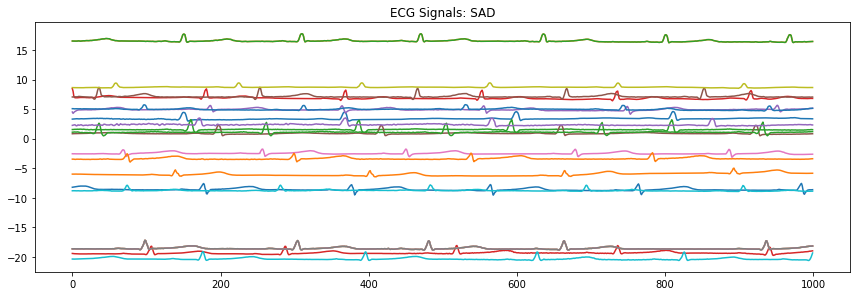

In [19]:
plot_signals(data_arr = sad_data, title = 'ECG Signals: SAD')

**FEAR**

<Figure size 432x288 with 0 Axes>

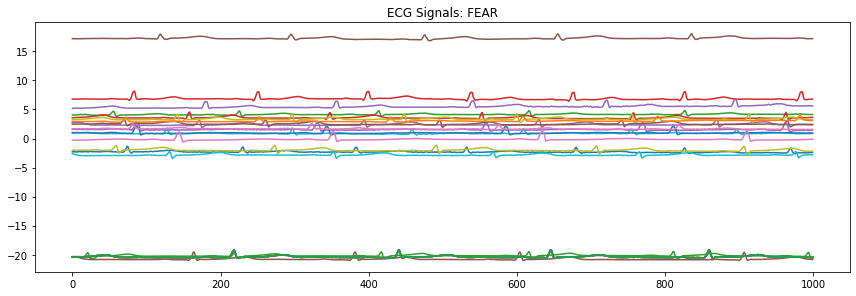

In [20]:
plot_signals(data_arr = fear_data, title = 'ECG Signals: FEAR')

**HAPPY**: Signals scatters on different levels

<Figure size 432x288 with 0 Axes>

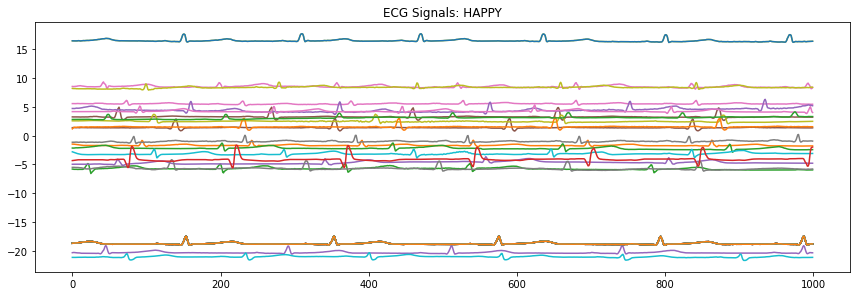

In [21]:
plot_signals(data_arr = happy_data, title = 'ECG Signals: HAPPY')

**ANGER**: Signals scatters on different levels

<Figure size 432x288 with 0 Axes>

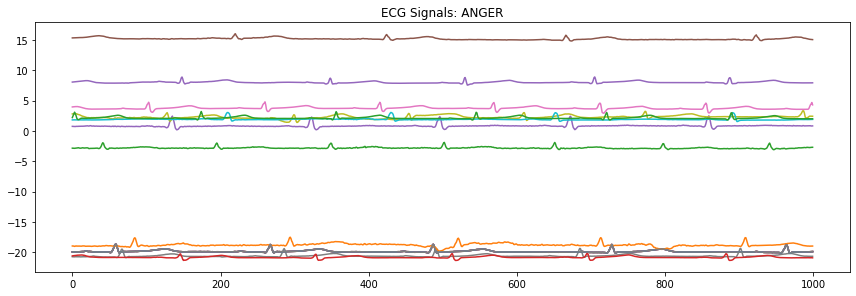

In [22]:
plot_signals(data_arr = anger_data, title = 'ECG Signals: ANGER')

**NEUTRAL**: Signals above 0 region are scatterd. Some are on -15 to -20 area

<Figure size 432x288 with 0 Axes>

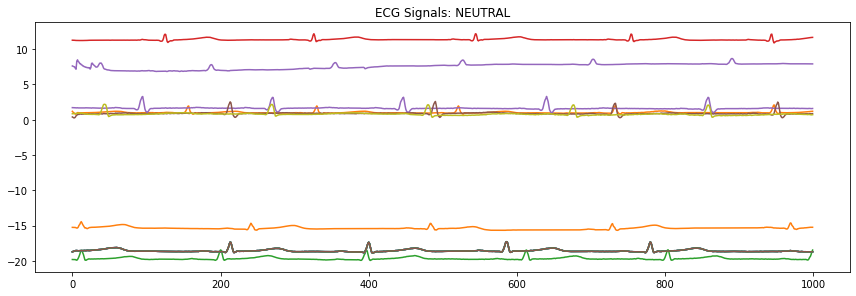

In [23]:
plot_signals(data_arr = neutral_data, title = 'ECG Signals: NEUTRAL')

**MIXED**: Most signals resides on zero level

<Figure size 432x288 with 0 Axes>

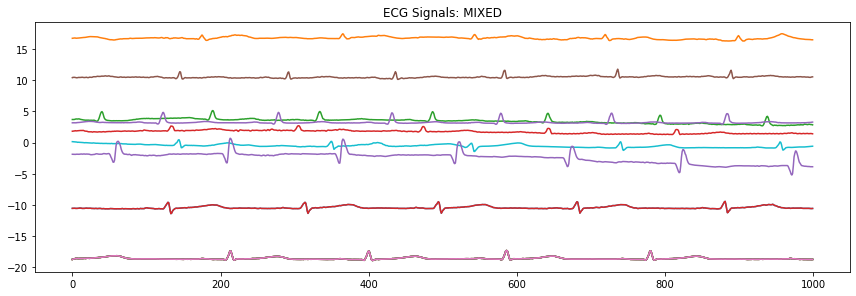

In [24]:
plot_signals(data_arr = mixed_data, title = 'ECG Signals: MIXED')

**DISGUST** : Signals are on 0-5 region and a lot on -20 level

<Figure size 432x288 with 0 Axes>

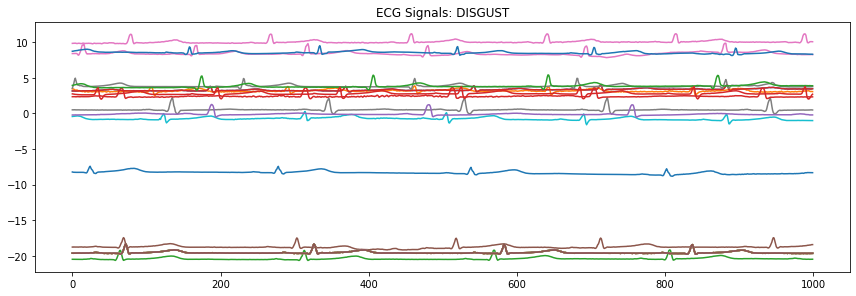

In [25]:
plot_signals(data_arr = disgust_data, title = 'ECG Signals: DISGUST')

**SURPRISED** : signals are all similar and residing near zero region

<Figure size 432x288 with 0 Axes>

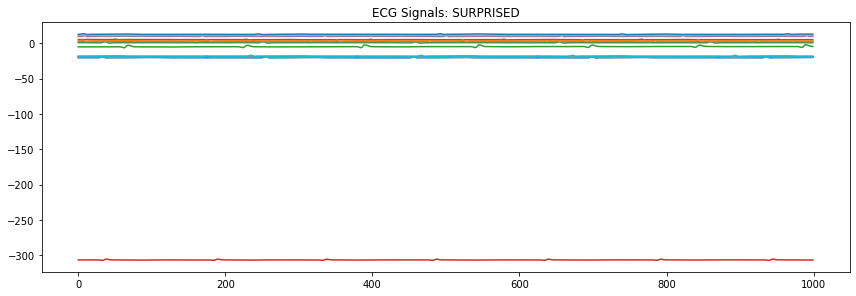

In [26]:
plot_signals(data_arr = surprised_data, title = 'ECG Signals: SURPRISED')

**Findings:** Uncertain on possible recognized pattern based on visual representation of the data

# Model creation and training

In [27]:
# # #train_d_frame = plot_frame.copy().drop(['Video ID', 'Valence level', 'Arousal level',
# # #                                        'Dominance level', 'Happy', 'Sad', 'Fear',
# # #                                        'Anger', 'Neutral', 'Disgust', 'Surprised',
# # #                                        'Valence', 'Arousal', 'Four label', 'Modal'
# # #                                       ], axis = 1)
train_d_frame = plot_frame.copy().drop(['Video ID', 'Happy', 'Sad', 'Fear',
                                        'Anger', 'Neutral', 'Disgust', 'Surprised', 'Four label', 'Modal'
                                       ], axis = 1)
train_d_frame.rename(columns = {'Raw Data':'feature', 'Emotion':'emotion'}, inplace = True)
#train_d_frame.head()


In [28]:
# train_d_frame = plot_frame.copy().drop(['Video ID', 'Happy', 'Sad', 'Fear',
#                                         'Anger', 'Neutral', 'Disgust', 'Surprised', 'Four label', 'Modal'
#                                        ], axis = 1)
# train_d_frame.rename(columns = {'Raw Data':'feature', 'Emotion':'emotion'}, inplace = True)
# #train_d_frame.head()


# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Activation

# # Prepare features and labels
# x = np.array(train_d_frame['feature'].tolist())  # Ensure 'feature' is a list of lists or arrays
# y = np.array(train_d_frame['emotion'].tolist())  # Ensure 'emotion' contains valid labels

# # Standardize features
# sc = StandardScaler()
# x = sc.fit_transform(x)

# # Encode labels
# labelencoder = LabelEncoder()
# y_encoded = labelencoder.fit_transform(y)  # Transform labels to integer values
# y = to_categorical(y_encoded)  # Convert to one-hot encoded format

# # Split data into training and testing sets
# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)

# # Define the number of labels
# num_labels = y.shape[1]

# # Build the model
# model = Sequential()

# # Input layer + first hidden layer
# model.add(Dense(8, input_shape=(x_train.shape[1],), activation='relu'))

# # Output layer
# model.add(Dense(num_labels, activation='softmax'))

In [29]:
# model.summary()

In [30]:
# model.compile(loss = 'categorical_crossentropy', metrics = ['accuracy'], optimizer = 'adam')

In [31]:
# # Define training settings
# num_epochs = 10
# num_batch_size = 10

# # Set up ModelCheckpoint
# checkpointer = ModelCheckpoint(filepath='./ecg_emotion_recognizer.hdf5', 
#                                 verbose=1, save_best_only=True)

# # Train the model
# start = datetime.now()
# model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs,
#           validation_data=(x_test, y_test), callbacks=[checkpointer], verbose=1)
# duration = datetime.now() - start
# print("Training completed in time: ", duration)



# Model accuracy

In [32]:
# # Evaluate the model
# test_accuracy = model.evaluate(x_test, y_test, verbose=0)
# print("Test Accuracy: ", test_accuracy)


# Initial Findings

**Initial Findings**: Model displayed low accuracy. Need to look for possible improvements. Will try feature extraction on raw data signals.

In [33]:
from __future__ import division
#from matplotlib import pyplot as plt
import scipy.io as spio
#import numpy as np
import statistics
from scipy.stats import kurtosis
from scipy.stats import skew
import sys
#sys.path.append("/home/chandan/python-workspace/")
#import BOCPD as ocpd #import bocpd from another file
import cProfile
from functools import partial

In [34]:

## Reference: https://github.com/chandanacharya1/ECG-Feature-extraction-using-Python/blob/master/features.py
####################### FEATURE DEFINITIONS ###################################


def detect_peaks(ecg_signal, threshold=0.3, qrs_filter=None):
    '''
    Peak detection algorithm using cross corrrelation and threshold 
    '''
    if qrs_filter is None:
        # create default qrs filter, which is just a part of the sine function
        t = np.linspace(1.5 * np.pi, 3.5 * np.pi, 15)
        qrs_filter = np.sin(t)
    
    # normalize data
    ecg_signal = (ecg_signal - ecg_signal.mean()) / ecg_signal.std()

    # calculate cross correlation
    similarity = np.correlate(ecg_signal, qrs_filter, mode="same")
    similarity = similarity / np.max(similarity)

    # return peaks (values in ms) using threshold
    return ecg_signal[similarity > threshold].index, similarity

def group_peaks(p, threshold=5):
    '''
    The peak detection algorithm finds multiple peaks for each QRS complex. 
    Here we group collections of peaks that are very near (within threshold) and we take the median index 
    '''
    # initialize output
    output = np.empty(0)

    # label groups of sample that belong to the same peak
    peak_groups, num_groups = sci_label(np.diff(p) < threshold)
 
    # iterate through groups and take the mean as peak index
    for i in np.unique(peak_groups)[1:]:
    #for i in np.unique(peak_groups):    
        peak_group = p[np.where(peak_groups == i)]
        output = np.append(output, np.median(peak_group))
    return output

"""TIME DOMAIN"""
#independent function to calculate RMSSD
def calc_rmssd(list):
    diff_nni = np.diff(list)#successive differences
    return np.sqrt(np.mean(diff_nni ** 2))
    
    
 #independent function to calculate AVRR   
def calc_avrr(list):
    return sum(list)/len(list)

 #independent function to calculate SDRR   
def calc_sdrr(list):
    return statistics.stdev(list)

 #independent function to calculate SKEW   
def calc_skew(list):
    return skew(list)

 #independent function to calculate KURT   
def calc_kurt(list):
    return kurtosis(list)

def calc_NNx(list):
    #diff_nni = np.diff(list)
    # detect peaks
    peaks, similarity = detect_peaks(list, threshold=0.3)
    # group peaks so we get a single peak per beat (hopefully)
    grouped_peaks = group_peaks(peaks)
    # RR-intervals are the differences between successive peaks
    rr = np.diff(grouped_peaks)
    nnxx = np.sum(np.abs(np.diff(rr)) > 50)*1
    #return sum(np.abs(diff_nni) > 50)
    return nnxx
    
def calc_pNNx(list):
    #length_int = len(list)
    #diff_nni = np.diff(list)
    #nni_50 = sum(np.abs(diff_nni) > 50)
    #return 100 * nni_50 / length_int
    # detect peaks
    peaks, similarity = detect_peaks(list, threshold=0.3)
    # group peaks so we get a single peak per beat (hopefully)
    grouped_peaks = group_peaks(peaks)
    # RR-intervals are the differences between successive peaks
    rr = np.diff(grouped_peaks)
    pnnxx = 100 * np.sum((np.abs(np.diff(rr)) > 50)*1) / len(rr)
    #return sum(np.abs(diff_nni) > 50)
    return pnnxx
    
"""NON LINEAR DOMAIN"""
 #independent function to calculate SD1
def calc_SD1(list):
    diff_nn_intervals = np.diff(list)
    return np.sqrt(np.std(diff_nn_intervals, ddof=1) ** 2 * 0.5)
 #independent function to calculate SD2
def calc_SD2(list):
    diff_nn_intervals = np.diff(list)
    return np.sqrt(2 * np.std(list, ddof=1) ** 2 - 0.5 * np.std(\
                   diff_nn_intervals, ddof=1) ** 2)
    
 #independent function to calculate SD1/SD2
def calc_SD1overSD2(list):
      diff_nn_intervals = np.diff(list)
      sd1 = np.sqrt(np.std(diff_nn_intervals, ddof=1) ** 2 * 0.5)
      sd2 = np.sqrt(2 * np.std(list, ddof=1) ** 2 - 0.5 * np.std(\
                    diff_nn_intervals, ddof=1) ** 2)
      ratio_sd2_sd1 = sd2 / sd1
      return ratio_sd2_sd1
    
    
 #independent function to calculate CSI
def calc_CSI(list):
    diff_nn_intervals = np.diff(list)
    sd1 = np.sqrt(np.std(diff_nn_intervals, ddof=1) ** 2 * 0.5)
    sd2 = np.sqrt(2 * np.std(list, ddof=1) ** 2 - 0.5 * np.std(\
                  diff_nn_intervals, ddof=1) ** 2)
    L=4 * sd1
    T=4 * sd2
    return L/T
       
 #independent function to calculate CVI
def calc_CVI(list):
    diff_nn_intervals = np.diff(list)
    sd1 = np.sqrt(np.std(diff_nn_intervals, ddof=1) ** 2 * 0.5)
    sd2 = np.sqrt(2 * np.std(list, ddof=1) ** 2 - 0.5 * np.std(\
                  diff_nn_intervals, ddof=1) ** 2)
    L=4 * sd1
    T=4 * sd2
    return np.log10(L * T)
 
 #independent function to calculate modified CVI
def calc_modifiedCVI(list):
    diff_nn_intervals = np.diff(list)
    sd1 = np.sqrt(np.std(diff_nn_intervals, ddof=1) ** 2 * 0.5)
    sd2 = np.sqrt(2 * np.std(list, ddof=1) ** 2 - 0.5 * np.std(\
                  diff_nn_intervals, ddof=1) ** 2)
    L=4 * sd1
    T=4 * sd2
    return L ** 2 / T


def calc_meanrr(list):
    # detect peaks
    peaks, similarity = detect_peaks(list, threshold=0.3)
    # group peaks so we get a single peak per beat (hopefully)
    grouped_peaks = group_peaks(peaks)
    # RR-intervals are the differences between successive peaks
    rr = np.diff(grouped_peaks)
    return np.mean(rr)

def calc_medianrr(list):
    # detect peaks
    peaks, similarity = detect_peaks(list, threshold=0.3)
    # group peaks so we get a single peak per beat (hopefully)
    grouped_peaks = group_peaks(peaks)
    # RR-intervals are the differences between successive peaks
    rr = np.diff(grouped_peaks)
    return np.median(rr)

    
def calc_hr(list):
    # detect peaks
    peaks, similarity = detect_peaks(list, threshold=0.3)
    # group peaks so we get a single peak per beat (hopefully)
    grouped_peaks = group_peaks(peaks)
    # RR-intervals are the differences between successive peaks
    rr = np.diff(grouped_peaks)
    hr = 60000/rr
    return np.mean(hr) 

    

In [35]:
extract_frame = train_d_frame.copy()
#hrv_data = train_d_frame.copy()

medianrr = []
meanrr = []
rmssd = []
sdrr_rmssd = []
hr = []
avrr = []
sdrr = []
skew_ = []
kurt = []
NNx = []
pNNx = []
SD1 = []
SD2 = []
CSI = []
CVI = []
modifiedCVI = []
SD1overSD2 = []
for index, row in extract_frame.iterrows():
    rmssd.append(calc_rmssd(row['feature']))
    avrr.append(calc_avrr(row['feature']))
    sdrr.append(calc_sdrr(row['feature']))
    skew_.append(calc_skew(row['feature']))
    kurt.append(calc_kurt(row['feature']))
    NNx.append(calc_NNx(pd.Series(row['feature'])))
    pNNx.append(calc_pNNx(pd.Series(row['feature'])))
    SD1.append(calc_SD1(row['feature']))
    SD2.append(calc_SD2(row['feature']))
    CSI.append(calc_CSI(row['feature']))
    CVI.append(calc_CVI(row['feature']))
    modifiedCVI.append(calc_modifiedCVI(row['feature']))
    SD1overSD2.append(calc_SD1overSD2(row['feature']))
    meanrr.append(calc_meanrr(pd.Series(row['feature'])))
    medianrr.append(calc_medianrr(pd.Series(row['feature'])))
    hr.append(calc_hr(pd.Series(row['feature'])))
    sdrrrmssd = calc_sdrr(row['feature']) / calc_rmssd(row['feature'])
    sdrr_rmssd.append(sdrrrmssd)
    

extract_frame['meanrr'] = meanrr
extract_frame['medianrr'] = medianrr
extract_frame['sdrr'] = sdrr
extract_frame['rmssd'] = rmssd
extract_frame['sdrr_rmssd'] = sdrr_rmssd
extract_frame['hr'] = hr
extract_frame['NNx'] = NNx
extract_frame['pNNx'] = pNNx
extract_frame['sd1'] = SD1
extract_frame['sd2'] = SD2
extract_frame['avrr'] = avrr
extract_frame['skew'] = skew_
extract_frame['kurt'] = kurt
extract_frame['avrr'] = avrr
extract_frame['csi'] = CSI
extract_frame['cvi'] = CVI
extract_frame['modifiedcvi'] = modifiedCVI

extract_frame = extract_frame.drop(['Valence level', 'Arousal level', 'Dominance level'], axis = 1)
extract_frame2 = extract_frame.copy()
extract_frame = extract_frame.drop(['feature', 'Target Emotion'], axis = 1)
extract_frame = extract_frame.drop(['Valence', 'Arousal'], axis = 1)
extract_frame = extract_frame.drop(['avrr', 'csi', 'cvi', 'modifiedcvi'], axis = 1)
extract_frame.head()

,emotion,meanrr,medianrr,sdrr,rmssd,sdrr_rmssd,hr,NNx,pNNx,sd1,sd2,skew,kurt
0,Anger,226.250,227.50,0.201542,0.066586,3.026793,266.042396,0,0.0,0.047107,0.281103,2.898871,10.845686
1,Mixed,187.875,186.00,0.233239,0.085923,2.714517,319.816288,0,0.0,0.060787,0.324200,0.875047,3.079515
2,Happy,219.500,221.50,0.197991,0.062261,3.180001,273.960919,0,0.0,0.044048,0.276516,2.842292,11.033996
3,Anger,209.625,194.25,0.221027,0.072777,3.037027,294.650732,1,25.0,0.051486,0.308310,3.158817,12.848869
4,Neutral,189.000,186.50,0.205307,0.064151,3.200358,317.593251,0,0.0,0.045385,0.286779,2.862825,11.344312


In [36]:
from sklearn import preprocessing
import seaborn as sns

In [37]:
#extract_frame = extract_frame2.drop(['feature'], axis = 1)
#extract_frame = extract_frame2.drop(['Target Emotion'], axis = 1)
le = preprocessing.LabelEncoder()
le.fit(extract_frame['emotion'])
extract_frame['emotion'] = le.transform(extract_frame['emotion'])


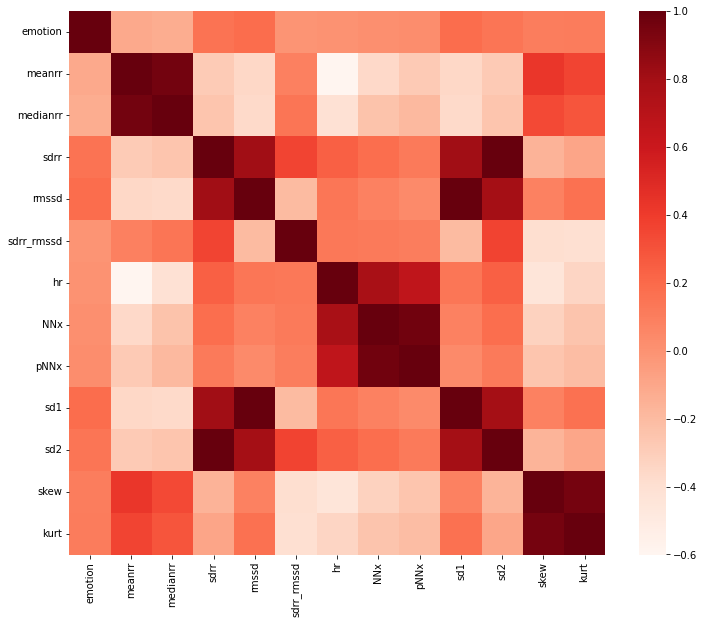

In [38]:
plt.figure(figsize=(12,10))
corr = extract_frame.corr()
sns.heatmap(corr, annot=False, cmap=plt.cm.Reds)
plt.show()

In [39]:
def feature_selection(correlation, threshold):
    selected_features = []
    for i in range(corr.shape[0]):
      if corr.iloc[i,0] > threshold:
        selected_features.append(extract_frame.iloc[:,i])
    return pd.DataFrame(selected_features).T

In [40]:
#extract_frame.head()

In [41]:
CORRELATION_THRESHOLD = 0.1
extract_frame = feature_selection(extract_frame, CORRELATION_THRESHOLD)
x = extract_frame.drop(['emotion'],axis=1)
y = extract_frame['emotion']
train_x, test_x, train_y, test_y = train_test_split(x, y, train_size=0.8, test_size=0.2, random_state=0)

extract_frame.head()

,emotion,sdrr,rmssd,sd1,sd2,skew,kurt
0,0.0,0.201542,0.066586,0.047107,0.281103,2.898871,10.845686
1,4.0,0.233239,0.085923,0.060787,0.324200,0.875047,3.079515
2,3.0,0.197991,0.062261,0.044048,0.276516,2.842292,11.033996
3,0.0,0.221027,0.072777,0.051486,0.308310,3.158817,12.848869
4,5.0,0.205307,0.064151,0.045385,0.286779,2.862825,11.344312


In [42]:
extract_frame["emotion"].tail()

394    4.0
395    3.0
396    3.0
397    2.0
398    5.0
Name: emotion, dtype: float64

# Decision Tree

In [43]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import classification_report, accuracy_score, f1_score, cohen_kappa_score, precision_score, roc_auc_score

# Initialize the Decision Tree Classifier
dt_model = DecisionTreeClassifier(criterion="entropy", max_depth=12)
# dt_model = dt_model.fit(train_x, train_y)
# dt_pred_y = dt_model.predict(test_x)

In [44]:
# Train the model
dt_model.fit(train_x, train_y)


DecisionTreeClassifier(criterion='entropy', max_depth=12)

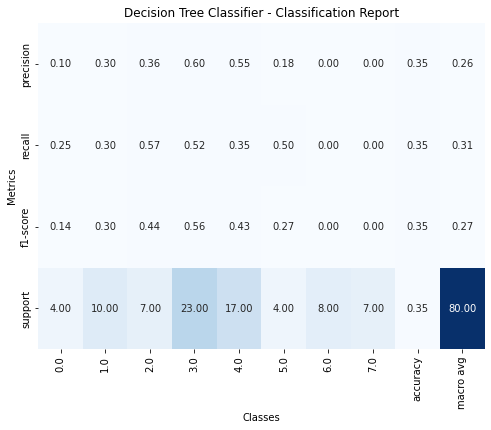

Train Accuracy: 0.780564263322884
Validation Accuracy: 0.35
Test Accuracy: 0.35
F1 Score: 0.3484016242155777
Cohen Kappa Score: 0.23515352086780672
Precision: 0.37181818181818177
AUC: 0.634255882643252


In [45]:
# Make predictions
train_pred_y = dt_model.predict(train_x)
val_pred_y = dt_model.predict(test_x)
test_pred_y = val_pred_y  # Since we only have test data

# Accuracy on train, validation (test), and overall
train_accuracy = accuracy_score(train_y, train_pred_y)
val_accuracy = accuracy_score(test_y, val_pred_y)

# F1-score, Cohen's Kappa, Precision, and AUC
f1 = f1_score(test_y, test_pred_y, average='weighted')  # Use weighted average for multi-class
kappa = cohen_kappa_score(test_y, test_pred_y)
precision = precision_score(test_y, test_pred_y, average='weighted')  # Precision for multi-class
try:
    auc = roc_auc_score(test_y, dt_model.predict_proba(test_x), multi_class='ovr', average='weighted')
except:
    auc = None  # AUC may not be possible for certain types of classifiers or data

# Generate classification report
dt_report = classification_report(test_y, test_pred_y, output_dict=True, zero_division=0)

# Convert classification report into DataFrame for plotting
dt_report_df = pd.DataFrame(dt_report).transpose()

# Plot the heatmap of the classification report
plt.figure(figsize=(8, 6))
sns.heatmap(dt_report_df.iloc[:-1, :].T, annot=True, cmap="Blues", fmt='.2f', cbar=False)

# Set the title and labels
plt.title('Decision Tree Classifier - Classification Report')
plt.ylabel('Metrics')
plt.xlabel('Classes')
plt.show()

# Print all metrics
print("Train Accuracy:", train_accuracy)
print("Validation Accuracy:", val_accuracy)
print("Test Accuracy:", accuracy_score(test_y, test_pred_y))
print("F1 Score:", f1)
print("Cohen Kappa Score:", kappa)
print("Precision:", precision)
print("AUC:", auc)

# Random Forest


In [46]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier()

In [47]:
# Train the model
rf_model.fit(train_x, train_y)

RandomForestClassifier()

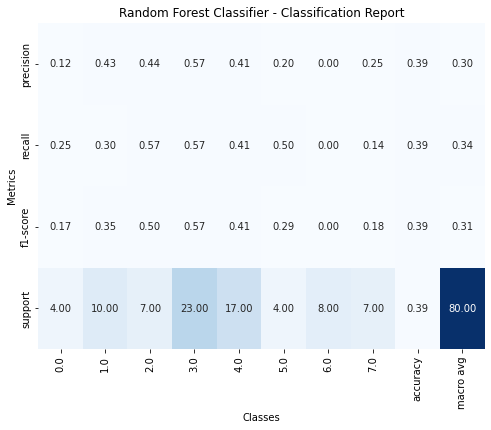

Train Accuracy: 0.780564263322884
Validation Accuracy: 0.3875
Test Accuracy: 0.3875
F1 Score: 0.3763957855869621
Cohen Kappa Score: 0.26495405962872676
Precision: 0.38058531746031743
AUC: 0.672625878337396


In [48]:

# Make predictions
train_pred_y = rf_model.predict(train_x)
val_pred_y = rf_model.predict(test_x)
test_pred_y = val_pred_y  # Since we only have test data

# Accuracy on train, validation (test), and overall
train_accuracy = accuracy_score(train_y, train_pred_y)
val_accuracy = accuracy_score(test_y, val_pred_y)

# F1-score, Cohen's Kappa, Precision, and AUC
f1 = f1_score(test_y, test_pred_y, average='weighted')  # Use weighted average for multi-class
kappa = cohen_kappa_score(test_y, test_pred_y)
precision = precision_score(test_y, test_pred_y, average='weighted')  # Precision for multi-class
try:
    auc = roc_auc_score(test_y, rf_model.predict_proba(test_x), multi_class='ovr', average='weighted')
except:
    auc = None  # AUC may not be possible for certain types of classifiers or data

# Generate classification report
rf_report = classification_report(test_y, test_pred_y, output_dict=True, zero_division=0)

# Convert classification report into DataFrame for plotting
rf_report_df = pd.DataFrame(rf_report).transpose()

# Plot the heatmap of the classification report
plt.figure(figsize=(8, 6))
sns.heatmap(rf_report_df.iloc[:-1, :].T, annot=True, cmap="Blues", fmt='.2f', cbar=False)

# Set the title and labels
plt.title('Random Forest Classifier - Classification Report')
plt.ylabel('Metrics')
plt.xlabel('Classes')
plt.show()

# Print all metrics
print("Train Accuracy:", train_accuracy)
print("Validation Accuracy:", val_accuracy)
print("Test Accuracy:", accuracy_score(test_y, test_pred_y))
print("F1 Score:", f1)
print("Cohen Kappa Score:", kappa)
print("Precision:", precision)
print("AUC:", auc)

# SVM

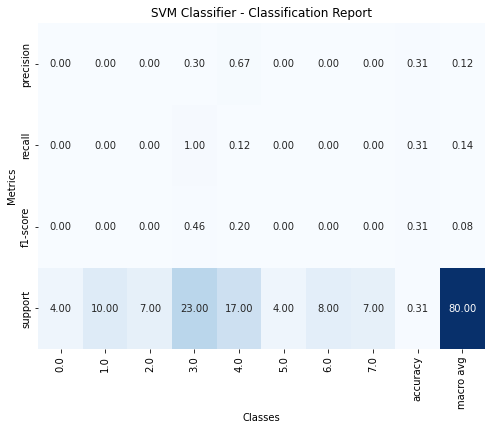

Train Accuracy: 0.27586206896551724
Validation Accuracy: 0.3125
Test Accuracy: 0.3125
F1 Score: 0.17475
Cohen Kappa Score: 0.038881607688946995
Precision: 0.22754329004329002
AUC: 0.46528663088943817


In [49]:
from sklearn.svm import SVC

# Initialize the Support Vector Machine Classifier
svm_model = SVC(probability=True, kernel='rbf', random_state=0)

# Train the model
svm_model.fit(train_x, train_y)

# Make predictions
train_pred_y = svm_model.predict(train_x)
val_pred_y = svm_model.predict(test_x)
test_pred_y = val_pred_y

# Accuracy on train, validation (test), and overall
train_accuracy = accuracy_score(train_y, train_pred_y)
val_accuracy = accuracy_score(test_y, val_pred_y)

# F1-score, Cohen's Kappa, Precision, and AUC
f1 = f1_score(test_y, test_pred_y, average='weighted', zero_division=0)  # Use weighted average for multi-class
kappa = cohen_kappa_score(test_y, test_pred_y)
precision = precision_score(test_y, test_pred_y, average='weighted', zero_division=0)  # Precision for multi-class
try:
    auc = roc_auc_score(test_y, svm_model.predict_proba(test_x), multi_class='ovr', average='weighted')
except:
    auc = None  # AUC may not be possible for certain types of classifiers or data

# Generate classification report
svm_report = classification_report(test_y, test_pred_y, output_dict=True, zero_division=0)

# Convert classification report into DataFrame for plotting
svm_report_df = pd.DataFrame(svm_report).transpose()

# Plot the heatmap of the classification report
plt.figure(figsize=(8, 6))
sns.heatmap(svm_report_df.iloc[:-1, :].T, annot=True, cmap="Blues", fmt='.2f', cbar=False)

# Set the title and labels
plt.title('SVM Classifier - Classification Report')
plt.ylabel('Metrics')
plt.xlabel('Classes')
plt.show()

# Print all metrics
print("Train Accuracy:", train_accuracy)
print("Validation Accuracy:", val_accuracy)
print("Test Accuracy:", accuracy_score(test_y, test_pred_y))
print("F1 Score:", f1)
print("Cohen Kappa Score:", kappa)
print("Precision:", precision)
print("AUC:", auc)


# AdaBoost

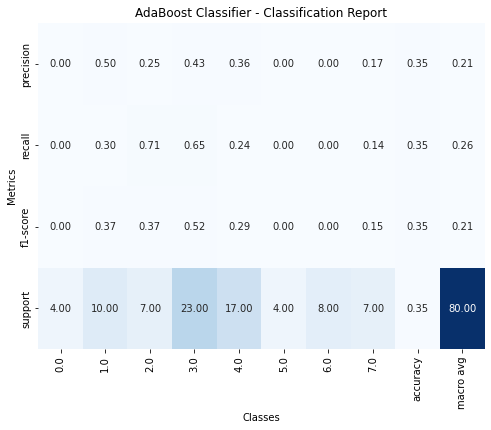

Train Accuracy: 0.34169278996865204
Validation Accuracy: 0.35
Test Accuracy: 0.35
F1 Score: 0.30216512813495566
Cohen Kappa Score: 0.192859914629414
Precision: 0.29944534632034625
AUC: 0.57386220259553


In [50]:
from sklearn.ensemble import AdaBoostClassifier

# Initialize the AdaBoost Classifier
ada_model = AdaBoostClassifier(n_estimators=70, random_state=0)

# Train the model
ada_model.fit(train_x, train_y)

# Make predictions
train_pred_y = ada_model.predict(train_x)
val_pred_y = ada_model.predict(test_x)
test_pred_y = val_pred_y

# Accuracy on train, validation (test), and overall
train_accuracy = accuracy_score(train_y, train_pred_y)
val_accuracy = accuracy_score(test_y, val_pred_y)

# F1-score, Cohen's Kappa, Precision, and AUC
f1 = f1_score(test_y, test_pred_y, average='weighted', zero_division=0)
kappa = cohen_kappa_score(test_y, test_pred_y)
precision = precision_score(test_y, test_pred_y, average='weighted', zero_division=0)
try:
    auc = roc_auc_score(test_y, ada_model.predict_proba(test_x), multi_class='ovr', average='weighted')
except:
    auc = None  # AUC may not be possible for certain types of classifiers or data

# Generate classification report
ada_report = classification_report(test_y, test_pred_y, output_dict=True, zero_division=0)

# Convert classification report into DataFrame for plotting
ada_report_df = pd.DataFrame(ada_report).transpose()

# Plot the heatmap of the classification report
plt.figure(figsize=(8, 6))
sns.heatmap(ada_report_df.iloc[:-1, :].T, annot=True, cmap="Blues", fmt='.2f', cbar=False)

# Set the title and labels
plt.title('AdaBoost Classifier - Classification Report')
plt.ylabel('Metrics')
plt.xlabel('Classes')
plt.show()

# Print all metrics
print("Train Accuracy:", train_accuracy)
print("Validation Accuracy:", val_accuracy)
print("Test Accuracy:", accuracy_score(test_y, test_pred_y))
print("F1 Score:", f1)
print("Cohen Kappa Score:", kappa)
print("Precision:", precision)
print("AUC:", auc)


# KNN

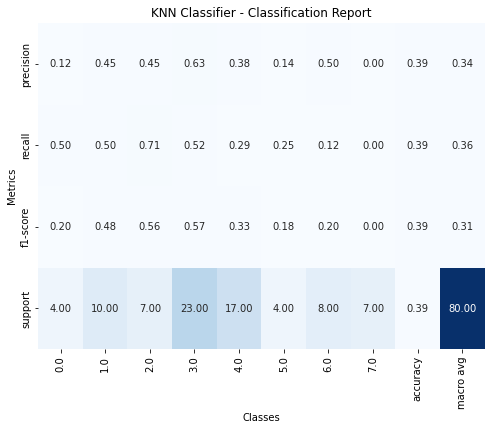

Train Accuracy: 0.4263322884012539
Validation Accuracy: 0.3875
Test Accuracy: 0.3875
F1 Score: 0.3823448773448773
Cohen Kappa Score: 0.27941176470588236
Precision: 0.42329348283295654
AUC: 0.651103239691695


In [51]:
from sklearn.neighbors import KNeighborsClassifier

# Initialize the KNN Classifier
knn_model = KNeighborsClassifier(n_neighbors=5)

# Train the model
knn_model.fit(train_x, train_y)

# Make predictions
train_pred_y = knn_model.predict(train_x)
val_pred_y = knn_model.predict(test_x)
test_pred_y = val_pred_y

# Accuracy on train, validation (test), and overall
train_accuracy = accuracy_score(train_y, train_pred_y)
val_accuracy = accuracy_score(test_y, val_pred_y)

# F1-score, Cohen's Kappa, Precision, and AUC
f1 = f1_score(test_y, test_pred_y, average='weighted', zero_division=0)
kappa = cohen_kappa_score(test_y, test_pred_y)
precision = precision_score(test_y, test_pred_y, average='weighted', zero_division=0)
try:
    auc = roc_auc_score(test_y, knn_model.predict_proba(test_x), multi_class='ovr', average='weighted')
except:
    auc = None

# Generate classification report
knn_report = classification_report(test_y, test_pred_y, output_dict=True, zero_division=0)

# Convert classification report into DataFrame for plotting
knn_report_df = pd.DataFrame(knn_report).transpose()

# Plot the heatmap of the classification report
plt.figure(figsize=(8, 6))
sns.heatmap(knn_report_df.iloc[:-1, :].T, annot=True, cmap="Blues", fmt='.2f', cbar=False)

# Set the title and labels
plt.title('KNN Classifier - Classification Report')
plt.ylabel('Metrics')
plt.xlabel('Classes')
plt.show()

# Print all metrics
print("Train Accuracy:", train_accuracy)
print("Validation Accuracy:", val_accuracy)
print("Test Accuracy:", accuracy_score(test_y, test_pred_y))
print("F1 Score:", f1)
print("Cohen Kappa Score:", kappa)
print("Precision:", precision)
print("AUC:", auc)


# XGBoost

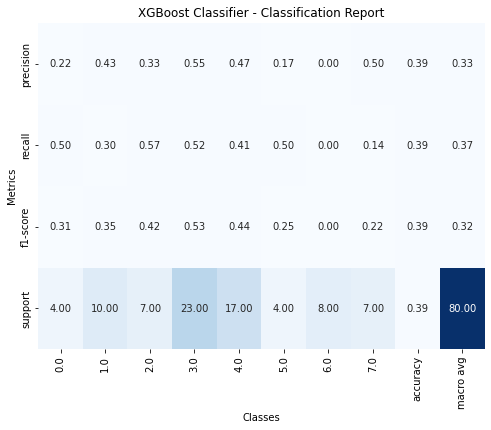

Train Accuracy: 0.7398119122257053
Validation Accuracy: 0.3875
Test Accuracy: 0.3875
F1 Score: 0.3745908954843745
Cohen Kappa Score: 0.27124000743632637
Precision: 0.4019173881673882
AUC: 0.6904938269618108


In [52]:
import xgboost as xgb

# Initialize the XGBoost Classifier
xgb_model = xgb.XGBClassifier(n_estimators=10, random_state=0)

# Train the model
xgb_model.fit(train_x, train_y)

# Make predictions
train_pred_y = xgb_model.predict(train_x)
val_pred_y = xgb_model.predict(test_x)
test_pred_y = val_pred_y

# Accuracy on train, validation (test), and overall
train_accuracy = accuracy_score(train_y, train_pred_y)
val_accuracy = accuracy_score(test_y, val_pred_y)

# F1-score, Cohen's Kappa, Precision, and AUC
f1 = f1_score(test_y, test_pred_y, average='weighted', zero_division=0)
kappa = cohen_kappa_score(test_y, test_pred_y)
precision = precision_score(test_y, test_pred_y, average='weighted', zero_division=0)
try:
    auc = roc_auc_score(test_y, xgb_model.predict_proba(test_x), multi_class='ovr', average='weighted')
except:
    auc = None

# Generate classification report
xgb_report = classification_report(test_y, test_pred_y, output_dict=True, zero_division=0)

# Convert classification report into DataFrame for plotting
xgb_report_df = pd.DataFrame(xgb_report).transpose()

# Plot the heatmap of the classification report
plt.figure(figsize=(8, 6))
sns.heatmap(xgb_report_df.iloc[:-1, :].T, annot=True, cmap="Blues", fmt='.2f', cbar=False)

# Set the title and labels
plt.title('XGBoost Classifier - Classification Report')
plt.ylabel('Metrics')
plt.xlabel('Classes')
plt.show()

# Print all metrics
print("Train Accuracy:", train_accuracy)
print("Validation Accuracy:", val_accuracy)
print("Test Accuracy:", accuracy_score(test_y, test_pred_y))
print("F1 Score:", f1)
print("Cohen Kappa Score:", kappa)
print("Precision:", precision)
print("AUC:", auc)


# Bagging

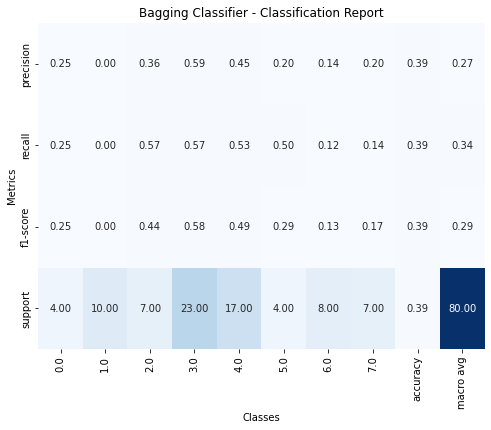

Train Accuracy: 0.780564263322884
Validation Accuracy: 0.3875
Test Accuracy: 0.3875
F1 Score: 0.36308075933075934
Cohen Kappa Score: 0.26315789473684215
Precision: 0.35161525974025976
AUC: 0.6898005466005195


In [53]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, cohen_kappa_score, precision_score, roc_auc_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Initialize the Bagging Classifier with a base classifier (DecisionTree in this case)
bagging_model = BaggingClassifier(base_estimator=DecisionTreeClassifier(),
                                  n_estimators=30,  # Number of base models
                                  random_state=0)

# Train the model
bagging_model.fit(train_x, train_y)

# Make predictions
train_pred_y = bagging_model.predict(train_x)
val_pred_y = bagging_model.predict(test_x)
test_pred_y = val_pred_y  # Since we only have test data

# Accuracy on train, validation (test), and overall
train_accuracy = accuracy_score(train_y, train_pred_y)
val_accuracy = accuracy_score(test_y, val_pred_y)

# F1-score, Cohen's Kappa, Precision, and AUC
f1 = f1_score(test_y, test_pred_y, average='weighted')  # Use weighted average for multi-class
kappa = cohen_kappa_score(test_y, test_pred_y)
precision = precision_score(test_y, test_pred_y, average='weighted')  # Precision for multi-class
try:
    auc = roc_auc_score(test_y, bagging_model.predict_proba(test_x), multi_class='ovr', average='weighted')
except:
    auc = None  # AUC may not be possible for certain types of classifiers or data

# Generate classification report
bagging_report = classification_report(test_y, test_pred_y, output_dict=True, zero_division=0)

# Convert classification report into DataFrame for plotting
bagging_report_df = pd.DataFrame(bagging_report).transpose()

# Plot the heatmap of the classification report
plt.figure(figsize=(8, 6))
sns.heatmap(bagging_report_df.iloc[:-1, :].T, annot=True, cmap="Blues", fmt='.2f', cbar=False)

# Set the title and labels
plt.title('Bagging Classifier - Classification Report')
plt.ylabel('Metrics')
plt.xlabel('Classes')
plt.show()

# Print all metrics
print("Train Accuracy:", train_accuracy)
print("Validation Accuracy:", val_accuracy)
print("Test Accuracy:", accuracy_score(test_y, test_pred_y))
print("F1 Score:", f1)
print("Cohen Kappa Score:", kappa)
print("Precision:", precision)
print("AUC:", auc)


# ANN

In [54]:
train_d_frame = plot_frame.copy().drop(['Video ID', 'Happy', 'Sad', 'Fear',
                                        'Anger', 'Neutral', 'Disgust', 'Surprised', 'Four label', 'Modal'
                                       ], axis = 1)
train_d_frame.rename(columns = {'Raw Data':'feature', 'Emotion':'emotion'}, inplace = True)
#train_d_frame.head()

In [55]:
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
import seaborn as sns

# Prepare features and labels
x = np.array(train_d_frame['feature'].tolist())  # Ensure 'feature' is a list of lists or arrays
y = np.array(train_d_frame['emotion'].tolist())  # Ensure 'emotion' contains valid labels

# Standardize features
sc = StandardScaler()
x = sc.fit_transform(x)

# Encode labels
labelencoder = LabelEncoder()
y_encoded = labelencoder.fit_transform(y)  # Transform labels to integer values
y = to_categorical(y_encoded)  # Convert to one-hot encoded format

# Split into train, validation, and test sets (80% train, 10% validation, 10% test)
x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.2, random_state=0)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=0)


In [56]:
# Initialize the ANN model
ann_model = Sequential()

# Input layer + First hidden layer
ann_model.add(Dense(64, input_dim=x_train.shape[1], activation='relu'))
ann_model.add(Dropout(0.5))  # Dropout for regularization

# # Second hidden layer
# ann_model.add(Dense(32, activation='relu'))
# ann_model.add(Dropout(0.3))

# Output layer
ann_model.add(Dense(y_train.shape[1], activation='softmax'))  # Number of classes = shape[1] of y_train

# Compile the model
ann_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

# Train the model
history = ann_model.fit(x_train, y_train, 
                        epochs=150, 
                        batch_size=32, 
                        validation_data=(x_val, y_val), 
                        verbose=1)

Epoch 1/150
10/10 [==============================] - 3s 21ms/step - loss: 2.4889 - accuracy: 0.1724 - val_loss: 2.2881 - val_accuracy: 0.1250
Epoch 2/150
10/10 [==============================] - 0s 5ms/step - loss: 2.9943 - accuracy: 0.1567 - val_loss: 2.0724 - val_accuracy: 0.2500
Epoch 3/150
10/10 [==============================] - 0s 5ms/step - loss: 2.5119 - accuracy: 0.1755 - val_loss: 2.0530 - val_accuracy: 0.2500
Epoch 4/150
10/10 [==============================] - 0s 5ms/step - loss: 2.4182 - accuracy: 0.1850 - val_loss: 1.9491 - val_accuracy: 0.2500
Epoch 5/150
10/10 [==============================] - 0s 5ms/step - loss: 2.6008 - accuracy: 0.2132 - val_loss: 1.9517 - val_accuracy: 0.2500
Epoch 6/150
10/10 [==============================] - 0s 5ms/step - loss: 2.6104 - accuracy: 0.1661 - val_loss: 2.0101 - val_accuracy: 0.2500
Epoch 7/150
10/10 [==============================] - 0s 5ms/step - loss: 2.7338 - accuracy: 0.2132 - val_loss: 2.0088 - val_accuracy: 0.2750
Epoch 8/150


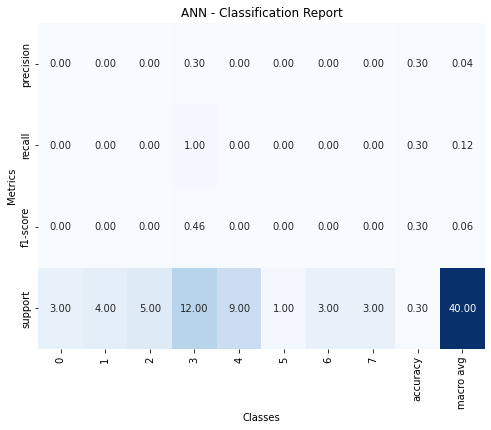

Train Accuracy: 0.2821316719055176
Validation Accuracy: 0.2750000059604645
Test Accuracy: 0.30000001192092896
F1 Score: 0.13846153846153847
Cohen Kappa Score: 0.0
Precision: 0.09
AUC: 0.44869414877479397


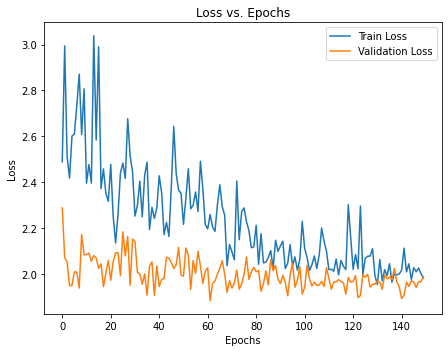

In [57]:
# Evaluate the model on training, validation, and test sets
train_accuracy = ann_model.evaluate(x_train, y_train, verbose=0)[1]
val_accuracy = ann_model.evaluate(x_val, y_val, verbose=0)[1]
test_accuracy = ann_model.evaluate(x_test, y_test, verbose=0)[1]

# Predictions
test_pred_prob = ann_model.predict(x_test)
test_pred_y = test_pred_prob.argmax(axis=1)
y_test_actual = y_test.argmax(axis=1)

# F1-score, Cohen's Kappa, Precision, and AUC
f1 = f1_score(y_test_actual, test_pred_y, average='weighted', zero_division=0)
kappa = cohen_kappa_score(y_test_actual, test_pred_y)
precision = precision_score(y_test_actual, test_pred_y, average='weighted', zero_division=0)
try:
    auc = roc_auc_score(y_test, test_pred_prob, multi_class='ovr', average='weighted')
except:
    auc = None

# Classification Report
ann_report = classification_report(y_test_actual, test_pred_y, output_dict=True, zero_division=0)

# Convert classification report into DataFrame for plotting
ann_report_df = pd.DataFrame(ann_report).transpose()

# Plot classification report as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(ann_report_df.iloc[:-1, :].T, annot=True, cmap="Blues", fmt='.2f', cbar=False)
plt.title('ANN - Classification Report')
plt.ylabel('Metrics')
plt.xlabel('Classes')
plt.show()

# Print all metrics
print("Train Accuracy:", train_accuracy)
print("Validation Accuracy:", val_accuracy)
print("Test Accuracy:", test_accuracy)
print("F1 Score:", f1)
print("Cohen Kappa Score:", kappa)
print("Precision:", precision)
print("AUC:", auc)

# Plot training vs validation accuracy and loss
plt.figure(figsize=(12, 5))

# # Accuracy plot
# plt.subplot(1, 2, 1)
# plt.plot(history.history['accuracy'], label='Train Accuracy')
# plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
# plt.title('Accuracy vs. Epochs')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


# LSTM

In [58]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, f1_score, accuracy_score, precision_score, cohen_kappa_score, roc_auc_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare features and labels
x = np.array(train_d_frame['feature'].tolist())  # Ensure 'feature' is a list of lists or arrays
y = np.array(train_d_frame['emotion'].tolist())  # Ensure 'emotion' contains valid labels

# Standardize features
sc = StandardScaler()
x = sc.fit_transform(x)

# Reshape for LSTM input (samples, timesteps, features)
x = x.reshape((x.shape[0], 1, x.shape[1]))  # Add a timesteps dimension (e.g., timesteps=1)

# Encode labels
labelencoder = LabelEncoder()
y_encoded = labelencoder.fit_transform(y)  # Transform labels to integer values
y = to_categorical(y_encoded)  # Convert to one-hot encoded format

# Split into train, validation, and test sets (80% train, 10% validation, 10% test)
x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.2, random_state=0)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=0)

# Initialize the LSTM model
lstm_model = Sequential()

# Add LSTM layer
lstm_model.add(LSTM(32, input_shape=(x_train.shape[1], x_train.shape[2]), activation='relu', return_sequences=False))
lstm_model.add(Dropout(0.2))  # Dropout for regularization

# Add output layer
lstm_model.add(Dense(y_train.shape[1], activation='softmax'))  # Number of classes = shape[1] of y_train

# Compile the model
lstm_model.compile(optimizer='adam',
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

# Train the model
history = lstm_model.fit(x_train, y_train,
                         epochs=50,
                         batch_size=32,
                         validation_data=(x_val, y_val),
                         verbose=1)


Epoch 1/50
10/10 [==============================] - 2s 33ms/step - loss: 2.1535 - accuracy: 0.1599 - val_loss: 2.0986 - val_accuracy: 0.1250
Epoch 2/50
10/10 [==============================] - 0s 8ms/step - loss: 2.1990 - accuracy: 0.2226 - val_loss: 2.0772 - val_accuracy: 0.2500
Epoch 3/50
10/10 [==============================] - 0s 8ms/step - loss: 2.0588 - accuracy: 0.2539 - val_loss: 2.0503 - val_accuracy: 0.2500
Epoch 4/50
10/10 [==============================] - 0s 9ms/step - loss: 2.0965 - accuracy: 0.2476 - val_loss: 2.0601 - val_accuracy: 0.2500
Epoch 5/50
10/10 [==============================] - 0s 8ms/step - loss: 2.0565 - accuracy: 0.2665 - val_loss: 2.0917 - val_accuracy: 0.2500
Epoch 6/50
10/10 [==============================] - 0s 8ms/step - loss: 2.0386 - accuracy: 0.2696 - val_loss: 2.0759 - val_accuracy: 0.2500
Epoch 7/50
10/10 [==============================] - 0s 8ms/step - loss: 2.0215 - accuracy: 0.2602 - val_loss: 2.0816 - val_accuracy: 0.2500
Epoch 8/50
10/10 [=

Train Accuracy: 0.2664576768875122
Validation Accuracy: 0.22499999403953552
Test Accuracy: 0.2750000059604645
F1 Score: 0.18896103896103894
Cohen Kappa Score: 0.02684563758389258
Precision: 0.15
AUC: 0.4758455313697249


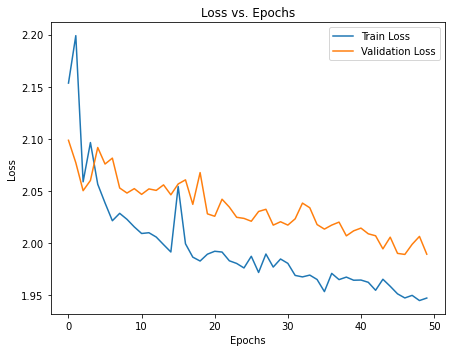

In [59]:
# Evaluate the model on training, validation, and test sets
train_accuracy = lstm_model.evaluate(x_train, y_train, verbose=0)[1]
val_accuracy = lstm_model.evaluate(x_val, y_val, verbose=0)[1]
test_accuracy = lstm_model.evaluate(x_test, y_test, verbose=0)[1]

# Predictions
test_pred_prob = lstm_model.predict(x_test)
test_pred_y = test_pred_prob.argmax(axis=1)
y_test_actual = y_test.argmax(axis=1)

# F1-score, Cohen's Kappa, Precision, and AUC
f1 = f1_score(y_test_actual, test_pred_y, average='weighted', zero_division=0)
kappa = cohen_kappa_score(y_test_actual, test_pred_y)
precision = precision_score(y_test_actual, test_pred_y, average='weighted', zero_division=0)
try:
    auc = roc_auc_score(y_test, test_pred_prob, multi_class='ovr', average='weighted')
except:
    auc = None

# Classification Report
lstm_report = classification_report(y_test_actual, test_pred_y, output_dict=True, zero_division=0)

# Convert classification report into DataFrame for plotting
lstm_report_df = pd.DataFrame(lstm_report).transpose()

# # Plot classification report as a heatmap
# plt.figure(figsize=(8, 6))
# sns.heatmap(lstm_report_df.iloc[:-1, :].T, annot=True, cmap="Blues", fmt='.2f', cbar=False)
# plt.title('LSTM - Classification Report')
# plt.ylabel('Metrics')
# plt.xlabel('Classes')
# plt.show()

# Print all metrics
print("Train Accuracy:", train_accuracy)
print("Validation Accuracy:", val_accuracy)
print("Test Accuracy:", test_accuracy)
print("F1 Score:", f1)
print("Cohen Kappa Score:", kappa)
print("Precision:", precision)
print("AUC:", auc)

# Plot training vs validation accuracy and loss
plt.figure(figsize=(12, 5))

# # Accuracy plot
# plt.subplot(1, 2, 1)
# plt.plot(history.history['accuracy'], label='Train Accuracy')
# plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
# plt.title('Accuracy vs. Epochs')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


# Bi-LSTM

In [60]:
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout


# Prepare features and labels
x = np.array(train_d_frame['feature'].tolist())  # Ensure 'feature' is a list of lists or arrays
y = np.array(train_d_frame['emotion'].tolist())  # Ensure 'emotion' contains valid labels

# Standardize features
sc = StandardScaler()
x = sc.fit_transform(x)

# Reshape for BI-LSTM input (samples, timesteps, features)
x = x.reshape((x.shape[0], 1, x.shape[1]))  # Add a timesteps dimension (e.g., timesteps=1)

# Encode labels
labelencoder = LabelEncoder()
y_encoded = labelencoder.fit_transform(y)  # Transform labels to integer values
y = to_categorical(y_encoded)  # Convert to one-hot encoded format

# Split into train, validation, and test sets (80% train, 10% validation, 10% test)
x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.2, random_state=0)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=0)

# Initialize the BI-LSTM model
bi_lstm_model = Sequential()

# Add Bidirectional LSTM layer
bi_lstm_model.add(Bidirectional(LSTM(32, activation='relu', return_sequences=False), input_shape=(x_train.shape[1], x_train.shape[2])))
# bi_lstm_model.add(Dropout(0.2))  # Dropout for regularization

# Add output layer
bi_lstm_model.add(Dense(y_train.shape[1], activation='softmax'))  # Number of classes = shape[1] of y_train

# Compile the model
bi_lstm_model.compile(optimizer='adam',
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

# Train the model
history = bi_lstm_model.fit(x_train, y_train,
                            epochs=50,
                            batch_size=32,
                            validation_data=(x_val, y_val),
                            verbose=1)


Epoch 1/50
10/10 [==============================] - 2s 41ms/step - loss: 2.3114 - accuracy: 0.2508 - val_loss: 2.0559 - val_accuracy: 0.2750
Epoch 2/50
10/10 [==============================] - 0s 9ms/step - loss: 2.3267 - accuracy: 0.2539 - val_loss: 2.0275 - val_accuracy: 0.2500
Epoch 3/50
10/10 [==============================] - 0s 9ms/step - loss: 2.1057 - accuracy: 0.2696 - val_loss: 1.9602 - val_accuracy: 0.2250
Epoch 4/50
10/10 [==============================] - 0s 11ms/step - loss: 2.1795 - accuracy: 0.2633 - val_loss: 2.0058 - val_accuracy: 0.2250
Epoch 5/50
10/10 [==============================] - 0s 12ms/step - loss: 2.1178 - accuracy: 0.2790 - val_loss: 2.0612 - val_accuracy: 0.2500
Epoch 6/50
10/10 [==============================] - 0s 13ms/step - loss: 2.1884 - accuracy: 0.2571 - val_loss: 1.9833 - val_accuracy: 0.2000
Epoch 7/50
10/10 [==============================] - 0s 11ms/step - loss: 2.0887 - accuracy: 0.2571 - val_loss: 1.9943 - val_accuracy: 0.2500
Epoch 8/50
10/1

Train Accuracy: 0.2915360629558563
Validation Accuracy: 0.25
Test Accuracy: 0.25
F1 Score: 0.125
Cohen Kappa Score: -0.06007067137809208
Precision: 0.08333333333333334
AUC: 0.44563939360310323


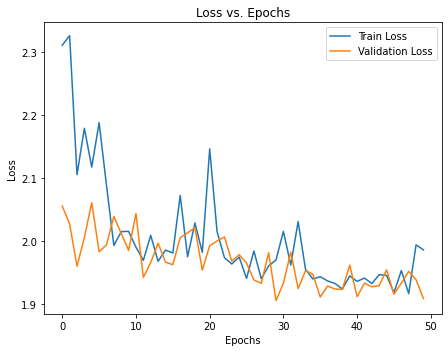

In [61]:
# Evaluate the model on training, validation, and test sets
train_accuracy = bi_lstm_model.evaluate(x_train, y_train, verbose=0)[1]
val_accuracy = bi_lstm_model.evaluate(x_val, y_val, verbose=0)[1]
test_accuracy = bi_lstm_model.evaluate(x_test, y_test, verbose=0)[1]

# Predictions
test_pred_prob = bi_lstm_model.predict(x_test)
test_pred_y = test_pred_prob.argmax(axis=1)
y_test_actual = y_test.argmax(axis=1)

# F1-score, Cohen's Kappa, Precision, and AUC
f1 = f1_score(y_test_actual, test_pred_y, average='weighted', zero_division=0)
kappa = cohen_kappa_score(y_test_actual, test_pred_y)
precision = precision_score(y_test_actual, test_pred_y, average='weighted', zero_division=0)
try:
    auc = roc_auc_score(y_test, test_pred_prob, multi_class='ovr', average='weighted')
except:
    auc = None

# Classification Report
bi_lstm_report = classification_report(y_test_actual, test_pred_y, output_dict=True, zero_division=0)

# Convert classification report into DataFrame for plotting
bi_lstm_report_df = pd.DataFrame(bi_lstm_report).transpose()

# # Plot classification report as a heatmap
# plt.figure(figsize=(8, 6))
# sns.heatmap(bi_lstm_report_df.iloc[:-1, :].T, annot=True, cmap="Blues", fmt='.2f', cbar=False)
# plt.title('BI-LSTM - Classification Report')
# plt.ylabel('Metrics')
# plt.xlabel('Classes')
# plt.show()

# Print all metrics
print("Train Accuracy:", train_accuracy)
print("Validation Accuracy:", val_accuracy)
print("Test Accuracy:", test_accuracy)
print("F1 Score:", f1)
print("Cohen Kappa Score:", kappa)
print("Precision:", precision)
print("AUC:", auc)

# Plot training vs validation accuracy and loss
plt.figure(figsize=(12, 5))

# # Accuracy plot
# plt.subplot(1, 2, 1)
# plt.plot(history.history['accuracy'], label='Train Accuracy')
# plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
# plt.title('Accuracy vs. Epochs')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [62]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout

# Prepare features and labels
x = np.array(train_d_frame['feature'].tolist())  # Ensure 'feature' is a list of lists or arrays
y = np.array(train_d_frame['emotion'].tolist())  # Ensure 'emotion' contains valid labels

# Standardize features
sc = StandardScaler()
x = sc.fit_transform(x)

# Reshape for 1D CNN input (samples, timesteps, features)
x = x.reshape((x.shape[0], x.shape[1], 1))  # Add a single feature channel dimension

# Encode labels
labelencoder = LabelEncoder()
y_encoded = labelencoder.fit_transform(y)  # Transform labels to integer values
y = to_categorical(y_encoded)  # Convert to one-hot encoded format

# Split into train, validation, and test sets (80% train, 10% validation, 10% test)
x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.2, random_state=0)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=0)

# Initialize the 1D CNN model
cnn_model = Sequential()

# Add convolutional layers
cnn_model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(x_train.shape[1], x_train.shape[2])))
cnn_model.add(MaxPooling1D(pool_size=2))  # Max pooling for down-sampling
cnn_model.add(Dropout(0.3))  # Dropout for regularization

# Add another convolutional layer
cnn_model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Dropout(0.3))

# Flatten the feature map
cnn_model.add(Flatten())

# Add a dense layer
cnn_model.add(Dense(64, activation='relu'))
cnn_model.add(Dropout(0.5))

# Add the output layer
cnn_model.add(Dense(y_train.shape[1], activation='softmax'))  # Number of classes = shape[1] of y_train

# Compile the model
cnn_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

# Train the model
history = cnn_model.fit(x_train, y_train,
                        epochs=50,
                        batch_size=32,
                        validation_data=(x_val, y_val),
                        verbose=1)



Epoch 1/50
10/10 [==============================] - 11s 38ms/step - loss: 2.2282 - accuracy: 0.2038 - val_loss: 2.0328 - val_accuracy: 0.2000
Epoch 2/50
10/10 [==============================] - 0s 11ms/step - loss: 2.1455 - accuracy: 0.1881 - val_loss: 2.0475 - val_accuracy: 0.2000
Epoch 3/50
10/10 [==============================] - 0s 10ms/step - loss: 2.0405 - accuracy: 0.2351 - val_loss: 2.0392 - val_accuracy: 0.2250
Epoch 4/50
10/10 [==============================] - 0s 10ms/step - loss: 2.0192 - accuracy: 0.2414 - val_loss: 1.9914 - val_accuracy: 0.2500
Epoch 5/50
10/10 [==============================] - 0s 9ms/step - loss: 2.0258 - accuracy: 0.2602 - val_loss: 1.9560 - val_accuracy: 0.2750
Epoch 6/50
10/10 [==============================] - 0s 9ms/step - loss: 1.9631 - accuracy: 0.2759 - val_loss: 1.9620 - val_accuracy: 0.2750
Epoch 7/50
10/10 [==============================] - 0s 9ms/step - loss: 1.9678 - accuracy: 0.2821 - val_loss: 1.9617 - val_accuracy: 0.2750
Epoch 8/50
10/1

Train Accuracy: 0.27899685502052307
Validation Accuracy: 0.2750000059604645
Test Accuracy: 0.30000001192092896
F1 Score: 0.13846153846153847
Cohen Kappa Score: 0.0
Precision: 0.09
AUC: 0.5996198050230308


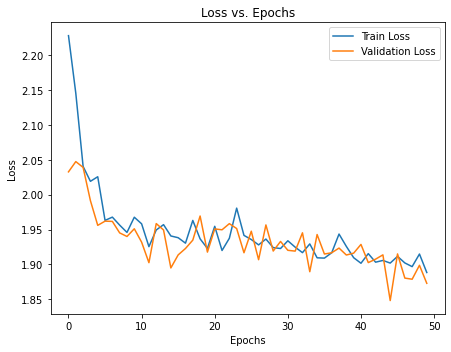

In [63]:

# Evaluate the model on training, validation, and test sets
train_accuracy = cnn_model.evaluate(x_train, y_train, verbose=0)[1]
val_accuracy = cnn_model.evaluate(x_val, y_val, verbose=0)[1]
test_accuracy = cnn_model.evaluate(x_test, y_test, verbose=0)[1]

# Predictions
test_pred_prob = cnn_model.predict(x_test)
test_pred_y = test_pred_prob.argmax(axis=1)
y_test_actual = y_test.argmax(axis=1)

# F1-score, Cohen's Kappa, Precision, and AUC
f1 = f1_score(y_test_actual, test_pred_y, average='weighted', zero_division=0)
kappa = cohen_kappa_score(y_test_actual, test_pred_y)
precision = precision_score(y_test_actual, test_pred_y, average='weighted', zero_division=0)
try:
    auc = roc_auc_score(y_test, test_pred_prob, multi_class='ovr', average='weighted')
except:
    auc = None

# Classification Report
cnn_report = classification_report(y_test_actual, test_pred_y, output_dict=True, zero_division=0)

# Convert classification report into DataFrame for plotting
cnn_report_df = pd.DataFrame(cnn_report).transpose()

# # Plot classification report as a heatmap
# plt.figure(figsize=(8, 6))
# sns.heatmap(cnn_report_df.iloc[:-1, :].T, annot=True, cmap="Blues", fmt='.2f', cbar=False)
# plt.title('1D CNN - Classification Report')
# plt.ylabel('Metrics')
# plt.xlabel('Classes')
# plt.show()

# Print all metrics
print("Train Accuracy:", train_accuracy)
print("Validation Accuracy:", val_accuracy)
print("Test Accuracy:", test_accuracy)
print("F1 Score:", f1)
print("Cohen Kappa Score:", kappa)
print("Precision:", precision)
print("AUC:", auc)

# Plot training vs validation accuracy and loss
plt.figure(figsize=(12, 5))

# # Accuracy plot
# plt.subplot(1, 2, 1)
# plt.plot(history.history['accuracy'], label='Train Accuracy')
# plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
# plt.title('Accuracy vs. Epochs')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
